## Install required libs, repos and MMDet toolbox
Restart the runtime after this step (to import mmdet)

In [1]:
import os
from os.path import exists, join, basename, splitext

# Dependencies for CascadeTabNet:
# libs stored on GDrive
%cd /content/drive/My Drive/tab_net/libs
!pip install torch-1.4.0+cu100-cp36-cp36m-linux_x86_64.whl
!pip install torchvision-0.5.0+cu100-cp36-cp36m-linux_x86_64.whl
!pip install -q mmcv==0.4.3 terminaltables

# Fork of author's repo:
# git_repo_url = 'https://github.com/br-eina/mmdetection_object_detection_demo'
git_repo_url = 'https://github.com/br-eina/tab_net_mmdet'

# Define mmdetection dir:
%cd /content
project_name = os.path.abspath(splitext(basename(git_repo_url))[0])
mmdetection_dir = os.path.join(project_name, "mmdetection")

# Install mmdetection:
if not exists(project_name):
    !git clone https://github.com/br-eina/tab_net_mmdet
    %cd /content/tab_net_mmdet
    # Clone "depth 1" will only get the last commits for every branch:
    !git clone -q --recurse-submodules --depth 1 --branch v1.2.0 https://github.com/open-mmlab/mmdetection.git
    # !git clone -q --recurse-submodules --depth 1 --no-single-branch $git_repo_url
    # Update mmdetection repo:
    !cd {mmdetection_dir} && git checkout v1.2.0 && git pull
    # Build mmdetection:
    !cd {mmdetection_dir} && python setup.py install
    !pip install -r {os.path.join(mmdetection_dir, "requirements.txt")}

Streaming output truncated to the last 5000 lines.
                 from /usr/local/lib/python3.6/dist-packages/torch/include/torch/csrc/api/include/torch/data/dataloader_options.h:4,
                 from /usr/local/lib/python3.6/dist-packages/torch/include/torch/csrc/api/include/torch/data/dataloader/base.h:3,
                 from /usr/local/lib/python3.6/dist-packages/torch/include/torch/csrc/api/include/torch/data/dataloader/stateful.h:3,
                 from /usr/local/lib/python3.6/dist-packages/torch/include/torch/csrc/api/include/torch/data/dataloader.h:3,
                 from /usr/local/lib/python3.6/dist-packages/torch/include/torch/csrc/api/include/torch/data.h:3,
                 from /usr/local/lib/python3.6/dist-packages/torch/include/torch/csrc/api/include/torch/all.h:4,
                 from /usr/local/lib/python3.6/dist-packages/torch/include/torch/extension.h:4,
                 from mmdet/ops/masked_conv/src/masked_conv2d_cuda.cpp:1:
/usr/local/lib/python3.6/dist-

## Define desired parameters:

In [1]:
pretr_model_epochs = {
    'icdar19': 36,
    'icdar13': 1
}

pretrained_model = 'icdar13'
dataset_type = 'type_opl_fact'
training_epochs = 6

pretr_epochs = pretr_model_epochs[pretrained_model]
total_epochs = pretr_epochs + training_epochs

## Change config

In [2]:
from os import listdir, makedirs
from os.path import isfile, join, exists
import re

def create_folders(*folders):
    for folder in folders:
        if not exists(folder):
            makedirs(folder)

config_path = '/content/tab_net_mmdet/configs/cascade_mask_rcnn_hrnetv2p_w32_20e.py'

data_root = f"/content/drive/My Drive/tab_net/training/{pretrained_model}/{dataset_type}/"
total_epochs_line = f"total_epochs = {total_epochs}"
data_root_line = f"data_root = '{data_root}'"
resume_from_line = f"resume_from = '/content/drive/My Drive/tab_net/pretrained_models/{pretrained_model}.pth'"


workdir = data_root + 'workdir/'
create_folders(workdir)

with open(config_path, 'r') as f:
    config = f.read()
    config = re.sub(r"total_epochs = \d+", total_epochs_line, config)
    config = re.sub(r"data_root = \'(.*?)\'", data_root_line, config)
    config = re.sub(r"resume_from = \'(.*?)\'", resume_from_line, config)
    
with open(config_path, 'w') as f:
    f.write(config)

## Train a model

In [3]:
%cd '/content'
%xmode Verbose
config_path = '/content/tab_net_mmdet/configs/cascade_mask_rcnn_hrnetv2p_w32_20e.py'
!python /content/tab_net_mmdet/mmdetection/tools/train.py {config_path}

/content
Exception reporting mode: Verbose
2020-09-28 09:39:43,134 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.6.9 (default, Jul 17 2020, 12:50:27) [GCC 8.4.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Cuda compilation tools, release 10.1, V10.1.243
GPU 0: Tesla K80
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
PyTorch: 1.4.0+cu100
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.21.1 (Git Hash 7d2fd500bc78936d1d648ca713b901012f470dbc)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CUDA Runtime 10.0
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,co

## Save predictions to JSON 

Select a pre-trained model (ICDAR13, ICDAR19, etc.)

That model was trained on certain part of custom dataset: 

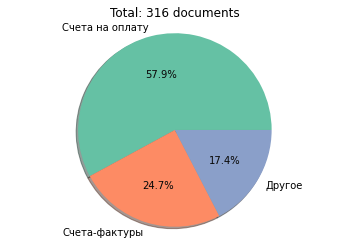

3 types of training:
- all 3 types (type_all);
- opl + fact (type_opl_fact);
- opl (type_opl)

There are corresponding train / test / unseeen lists for each type of training. Select one of them. 

Each model was trained during 8 epoches. For every epoch we evaluate the results on train / test / unseen images.


-----------------------------------------------

In [4]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
from tqdm.notebook import tqdm
import json
import shutil
from os import listdir
from os.path import isfile, join

# Define paths for images and train/test/unseen lists
gen_dir = f'/content/drive/My Drive/tab_net/'
images_folder = gen_dir + 'images/'
list_dir = gen_dir + f'training/{pretrained_model}/{dataset_type}/'

train_list_path = list_dir + 'train_list.json'
test_list_path = list_dir + 'test_list.json'
unseen_list_path = list_dir + 'unseen_list.json'

# Load train, test, unseen imagenames:
with open(train_list_path, 'r+') as f:
    train_list = json.load(f)
with open(test_list_path, 'r+') as f:
    test_list = json.load(f)
with open(unseen_list_path, 'r+') as f:
    unseen_list = json.load(f)

Create a JSON with results for a model:
1. which was pretrained on a spefic dataset (icdar13/19...)
2. which was trained on a part of custom dataset (type_all, type_opl, ...)

*Data structure:*
```
{
 'dataset_type': 'type_all / ...',
 'results': [
             {
              'epoch': X,
              'results_train': [
                                {
                                 'image_name': 'imgname',
                                 'tables_bordered' : [
                                                      {
                                                       'bbox': [x1, y1, x2, y2],
                                                       'conf': confidence
                                                      }, ...
                                                     ],
                                 'cells': [ ... ],
                                 'tables_borderless': [ ... ]
                                }, ....           
                               ]
              'results_test': [ ... ],
              'results_unseen': [ ... ]
             }
            ]
}
```


In [5]:
model_results = dict()
model_results["dataset_type"] = dataset_type
model_results["results"] = []

epochs = [epoch for epoch in range(pretr_epochs, total_epochs + 1)]
# Construct model_results JSON:
for epoch_num in epochs:
    # Load model for epoch:
    if epoch_num == epochs[0]:
        checkpoint_file = gen_dir + f'pretrained_models/{pretrained_model}.pth'
    else:
        checkpoint_file = list_dir + f'workdir/epoch_{str(epoch_num)}.pth'
    model = init_detector(config_path, checkpoint_file, device='cuda:0')
    # Define dict structure for results on epoch:
    epoch_x = dict()
    epoch_x["epoch"] = epoch_num
    epoch_x["results_train"] = []
    epoch_x["results_test"] = []
    epoch_x["results_unseen"] = []

    print(f'\nEpoch {epoch_num}: initiate processing: \n')

    lists_eval = {
        "train_list": train_list,
        "test_list": test_list,
        "unseen_list": unseen_list
    }

    for list_name in lists_eval:
        current_list = lists_eval[list_name]
        print(f'Processing {len(current_list)} images in {list_name}:')
        pbar = tqdm(current_list)
        for ind, image_name in enumerate(pbar):
            pbar.set_description(f'Image #{ind+1}: {image_name}')
            image_path = images_folder + image_name
            inf_result = inference_detector(model, image_path)
            # Define dict structure for image results
            image_results = dict()
            image_results["image_name"] = image_name
            image_results["tables_bordered"] = []
            image_results["cells"] = []
            image_results["tables_borderless"] = []           

            det_objects = {
                "tables_bordered": inf_result[0][0],
                "cells": inf_result[0][1],
                "tables_borderless": inf_result[0][2]
            }
            # For every type of object (tables/cell):
            for object_type in det_objects:
                current_objects = det_objects[object_type]
                if current_objects.any():
                    # Add object (table/cell) info to image results
                    for obj in current_objects:
                        x1, y1, x2, y2, conf = [round(val, 3) for val in obj.tolist()]
                        obj_info = dict()
                        obj_info["bbox"] = [x1, y1, x2, y2]
                        obj_info["conf"] = conf
                        image_results[object_type].append(obj_info)
            # Add image results to corresponding list (results_train/test/unseen)
            epoch_x[f"results_{list_name.split('_')[0]}"].append(image_results)

    model_results["results"].append(epoch_x)

# Save model results as JSON:
results_json_path = gen_dir + f'results/{pretrained_model}_{dataset_type}_results.json'
with open(results_json_path, 'w+') as f:
    json.dump(model_results, f, indent=4)


# Locate log training file path:
# TODO: take the latest log
workdir_path = f'/content/drive/My Drive/tab_net/training/{pretrained_model}/{dataset_type}/workdir/'
workdir_filenames = [f for f in listdir(workdir_path) if isfile(join(workdir_path, f))]
for filename in workdir_filenames:
    if filename.endswith('.log.json'):
        log_filename = filename
log_path = workdir_path + log_filename

# Save log training file in results/ folder
shutil.copy2(log_path, f'{gen_dir}results/{pretrained_model}_{dataset_type}.log.json')


Epoch 1: initiate processing: 

Processing 166 images in train_list:



Processing 42 images in test_list:



Processing 53 images in unseen_list:




Epoch 2: initiate processing: 

Processing 166 images in train_list:



Processing 42 images in test_list:



Processing 53 images in unseen_list:




Epoch 3: initiate processing: 

Processing 166 images in train_list:



Processing 42 images in test_list:



Processing 53 images in unseen_list:




Epoch 4: initiate processing: 

Processing 166 images in train_list:



Processing 42 images in test_list:



Processing 53 images in unseen_list:




Epoch 5: initiate processing: 

Processing 166 images in train_list:



Processing 42 images in test_list:



Processing 53 images in unseen_list:




Epoch 6: initiate processing: 

Processing 166 images in train_list:



Processing 42 images in test_list:



Processing 53 images in unseen_list:




Epoch 7: initiate processing: 

Processing 166 images in train_list:



Processing 42 images in test_list:



Processing 53 images in unseen_list:


'/content/drive/My Drive/tab_net/results/icdar13_type_opl_fact.log.json'

# Debug section

## Dataframe construction:

In [ ]:
from os import listdir
from os.path import isfile, join
import ast


gen_dir = f'/content/drive/My Drive/tab_net/'
images_folder = gen_dir + 'images/'
list_dir = gen_dir + f'training/{pretrained_model}/{dataset_type}/'

workdir_path = f'/content/drive/My Drive/tab_net/training/{pretrained_model}/{dataset_type}/workdir/'

workdir_filenames = [f for f in listdir(workdir_path) if isfile(join(workdir_path, f))]

for filename in workdir_filenames:
    if filename.endswith('.log.json'):
        log_filename = filename

log_path = workdir_path + log_filename

total_log = []
with open(log_path, 'r') as f:
    for ind, line in enumerate(f):
        if ind != 0:
            log_line = ast.literal_eval(line)
            total_log.append(log_line)

total_log = sorted(total_log, key=lambda k: (k['epoch'], k['iter']))



data = []  
epoches = [36, 37, 38, 39, 40, 41, 42]
eval_types = ['train', 'test', 'unseen']
for epoch in epoches:
    for eval_type in eval_types:
        icdar19_type_all_results_path = f'results/results_{epoch}_{eval_type}.txt'
        # Parse precision and recall:
        with open(icdar19_type_all_results_path, 'r') as f:
            for line in f:
                if line.startswith('Precision'):
                    prec_line = line.rstrip()
                if line.startswith('Recall'):
                    recall_line = line.rstrip()
                if line.startswith('AP:'):
                    ap_line = line.rstrip()
        for line in (prec_line, recall_line):
            arr_str = line[line.find('[') :]
            if line == prec_line:
                precision = np.array([float(val) for val in ast.literal_eval(arr_str)])
            elif line == recall_line:
                recall = np.array([float(val) for val in ast.literal_eval(arr_str)])
        
        ap_percent = ap_line.split(' ')[1]
        ap = float(ap_percent[:len(ap_percent)-1])
        ap = ap / 100

        data_line = dict()
        data_line['pretrained_model'] = 'icdar19'
        data_line['dataset_type'] = 'type_all'
        data_line['epoch'] = epoch
    
        # Handle log:
        data_line['log'] = []
        if epoch != 36:
            for log_line in total_log:
                data_line['log'].append(log_line)
                if log_line['epoch'] == epoch and log_line['iter'] == 100:
                    break
        data_line['evaluate'] = eval_type
        data_line['precision'] = precision
        data_line['recall'] = recall
        data_line['ap'] = ap
        data.append(data_line)

df_data_with_log = pd.DataFrame(data)
df_data_with_log

[{'data_time': 0.79064,
  'epoch': 37,
  'iter': 10,
  'loss': 0.77587,
  'loss_rpn_bbox': 0.01872,
  'loss_rpn_cls': 0.02643,
  'lr': 1e-05,
  'memory': 8220,
  'mode': 'train',
  's0.acc': 93.86719,
  's0.loss_bbox': 0.01031,
  's0.loss_cls': 0.1915,
  's0.loss_mask': 0.18179,
  's1.acc': 89.48242,
  's1.loss_bbox': 0.0203,
  's1.loss_cls': 0.15499,
  's1.loss_mask': 0.04747,
  's2.acc': 87.28516,
  's2.loss_bbox': 0.02297,
  's2.loss_cls': 0.09049,
  's2.loss_mask': 0.01089,
  'time': 1.64663},
 {'data_time': 0.00985,
  'epoch': 37,
  'iter': 20,
  'loss': 1.00329,
  'loss_rpn_bbox': 0.01309,
  'loss_rpn_cls': 0.02418,
  'lr': 1e-05,
  'memory': 8220,
  'mode': 'train',
  's0.acc': 93.82812,
  's0.loss_bbox': 0.02168,
  's0.loss_cls': 0.19074,
  's0.loss_mask': 0.35298,
  's1.acc': 89.76562,
  's1.loss_bbox': 0.03336,
  's1.loss_cls': 0.14864,
  's1.loss_mask': 0.07649,
  's2.acc': 86.91406,
  's2.loss_bbox': 0.03268,
  's2.loss_cls': 0.08955,
  's2.loss_mask': 0.01988,
  'time': 0.

## Predict tables for a specific image:

In [ ]:
%cd /content/drive/My Drive/colab_env
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
import json

# Load model:
gen_dir = '/content/drive/My Drive/colab_env/tab_net_finetuning/'
list_dir = gen_dir + 'type_all/'
config_file = '/content/mmdetection_object_detection_demo/cascade_mask_rcnn_hrnetv2p_w32_20e.py'
# checkpoint_file = list_dir + 'workdir/epoch_42.pth'
checkpoint_file = gen_dir + 'epoch_1_ICDAR13.pth'
model = init_detector(config_file, checkpoint_file, device='cuda:0')

# Load train, test, unseen imagenames:
images_folder = gen_dir + 'images/'
train_list_path = list_dir + 'train_list.json'
test_list_path = list_dir + 'test_list.json'
unseen_list_path = list_dir + 'unseen_list.json'

with open(train_list_path, 'r+') as f:
    train_list = json.load(f)
with open(test_list_path, 'r+') as f:
    test_list = json.load(f)
with open(unseen_list_path, 'r+') as f:
    unseen_list = json.load(f)

/content/drive/My Drive/colab_env


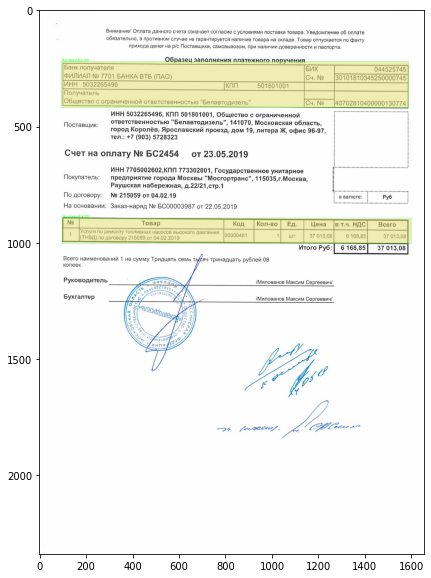

In [ ]:
image_path = images_folder + unseen_list[43]

# Run Inference:
result = inference_detector(model, image_path)
# Visualization results:
show_result_pyplot(image_path, result,('Bordered', 'cell', 'Borderless'), score_thr=0.85)

In [ ]:
result[0][:3]

[array([[8.51222229e+01, 4.58633240e+02, 2.24336646e+03, 1.00655975e+03,
         9.99993682e-01]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32)]

----------------------------------------------------------------------

In [ ]:
%cd /content

# log_file = '/content/drive/My Drive/colab_env/tab_net_finetuning/type_all/workdir/20200923_121722.log.json'
log_file = '/content/drive/My Drive/colab_env/tab_net_finetuning/type_all/workdir/20200924_094710.log.json'
pdf_file = '/content/drive/My Drive/colab_env/tab_net_finetuning/type_all/workdir/losses.pdf'
!python /content/mmdetection_object_detection_demo/mmdetection/tools/analyze_logs.py plot_curve log.json --keys s0.loss_bbox --out s0_loss_bbox.pdf

/content
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
plot curve of log.json, metric is s0.loss_bbox
save curve to: s0_loss_bbox.pdf


In [ ]:
for table_bbox in result[0][0]:
    print(table_bbox)

[5.7001457e+01 5.8826428e+02 2.3068550e+03 1.0529600e+03 9.9898392e-01]


In [ ]:
if result[0][1].any():
    print(True)
else:
    print(False)

False


In [ ]:
result[0][0][0]

array([5.7001457e+01, 5.8826428e+02, 2.3068550e+03, 1.0529600e+03,
       9.9898392e-01], dtype=float32)

In [ ]:
x = None
if x:
    print(True)
else:
    print(False)

False


In [ ]:
x1, y1, x2, y2, conf = result[0][0][0]
x1, y1, x2, y2, conf

(57.001457, 588.2643, 2306.855, 1052.96, 0.9989839)

In [ ]:
import numpy as np

arr = np.array([57.335235, 588.221424, 2306.42112, 1052.71212, 0.9942241], dtype=np.float32)

list_arr = arr.tolist()
list_arr

[57.335235595703125,
 588.221435546875,
 2306.421142578125,
 1052.712158203125,
 0.9942240715026855]

In [ ]:
x1, y1, x2, y2, conf = [round(val, 3) for val in list_arr]
x1, y1, x2, y2, conf

(57.335, 588.221, 2306.421, 1052.712, 0.994)

In [ ]:
x1, y1, x2, y2, conf = [round(val, 3) for val in arr]
x1, y1, x2, y2, conf

(57.335, 588.221, 2306.421, 1052.712, 0.994)

In [ ]:
type(x1)

numpy.float32

In [ ]:
x1, y1, x2, y2, conf = [round(val, 3) for val in arr.tolist()]
x1, y1, x2, y2, conf

(57.335, 588.221, 2306.421, 1052.712, 0.994)

In [ ]:
type(x1)

float

In [ ]:
a = "train_list"
a.split('_')[0]

'train'